In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ultralytics import YOLO
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
cwd = os.getcwd()
TEST_DATA_PATH = os.path.join(cwd, "dataset", "test")

# Ruta donde se guardaron los entrenamientos del paso anterior
PROJECT_PATH = os.path.join(cwd, "runs")

# Modelos a evaluar
variants = ['n', 's', 'm']

df = pd.read_csv("full_dataset/ISIC_2019_Training_GroundTruth.csv")
df = df.drop("UNK", axis=1)

target_names = [c for c in df.columns[1:]]

In [4]:
def evaluate_model(model_path, test_path, class_list):
    print(f"Cargando modelo: {model_path}")
    model = YOLO(model_path)
    
    y_true = []
    y_pred = []
    
    # Iteramos sobre cada carpeta de clase (MEL, NV, etc.)
    for class_name in os.listdir(test_path):
        class_dir = os.path.join(test_path, class_name)
        if not os.path.isdir(class_dir): continue
            
        # Obtenemos el índice numérico de la clase (ej: MEL = 0)
        if class_name in class_list:
            class_idx = class_list.index(class_name)
        else:
            continue
            
        # Listamos imágenes
        images = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.endswith(('.jpg', '.jpeg', '.png'))]
        
        if not images: continue

        # Hacemos predicción en lote (más rápido)
        # stream=False devuelve una lista de objetos Result
        results = model.predict(images, verbose=False, imgsz=224)
        
        for res in results:
            # probs.top1 devuelve el índice de la clase con mayor probabilidad
            pred_idx = res.probs.top1
            
            y_true.append(class_idx)
            y_pred.append(pred_idx)
            
    return y_true, y_pred


-------------------Evaluando yolo11n-cls.pt-------------------
Cargando modelo: c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Aprendizaje_Automatico\practicas-aprendizaje\practica4\runs\train_yolo11n-cls.pt\weights\best.pt
Accuracy Global: 0.0500

Reporte de Clasificación:
              precision    recall  f1-score   support

         MEL       0.07      0.10      0.08        10
          NV       0.00      0.00      0.00        10
         BCC       0.09      0.10      0.10        10
          AK       0.00      0.00      0.00        10
         BKL       0.00      0.00      0.00        10
          DF       0.18      0.20      0.19        10
        VASC       0.00      0.00      0.00        10
         SCC       0.00      0.00      0.00        10

    accuracy                           0.05        80
   macro avg       0.04      0.05      0.05        80
weighted avg       0.04      0.05      0.05        80



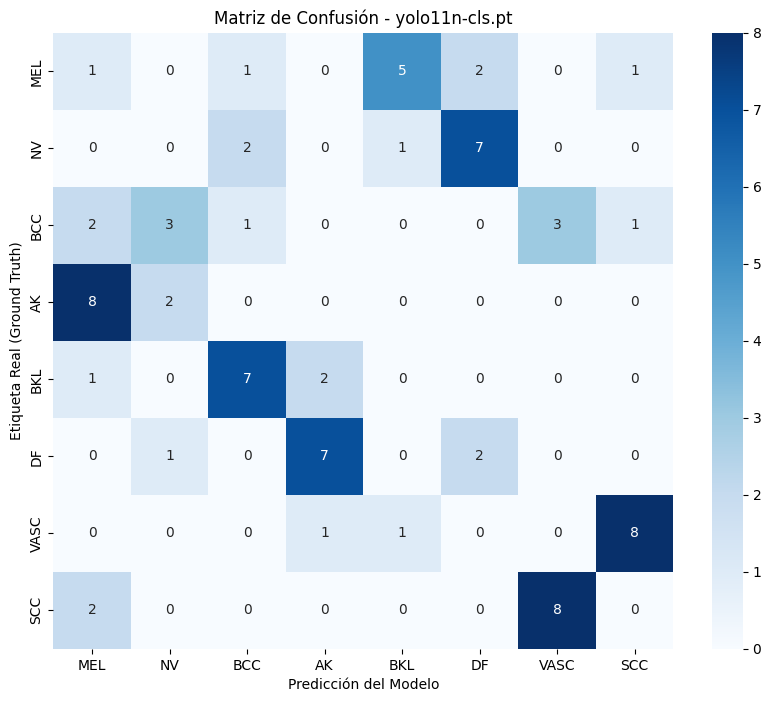


-------------------Evaluando yolo11s-cls.pt-------------------
Cargando modelo: c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Aprendizaje_Automatico\practicas-aprendizaje\practica4\runs\train_yolo11s-cls.pt\weights\best.pt
Accuracy Global: 0.0375

Reporte de Clasificación:
              precision    recall  f1-score   support

         MEL       0.06      0.10      0.08        10
          NV       0.00      0.00      0.00        10
         BCC       0.00      0.00      0.00        10
          AK       0.00      0.00      0.00        10
         BKL       0.10      0.10      0.10        10
          DF       0.10      0.10      0.10        10
        VASC       0.00      0.00      0.00        10
         SCC       0.00      0.00      0.00        10

    accuracy                           0.04        80
   macro avg       0.03      0.04      0.03        80
weighted avg       0.03      0.04      0.03        80



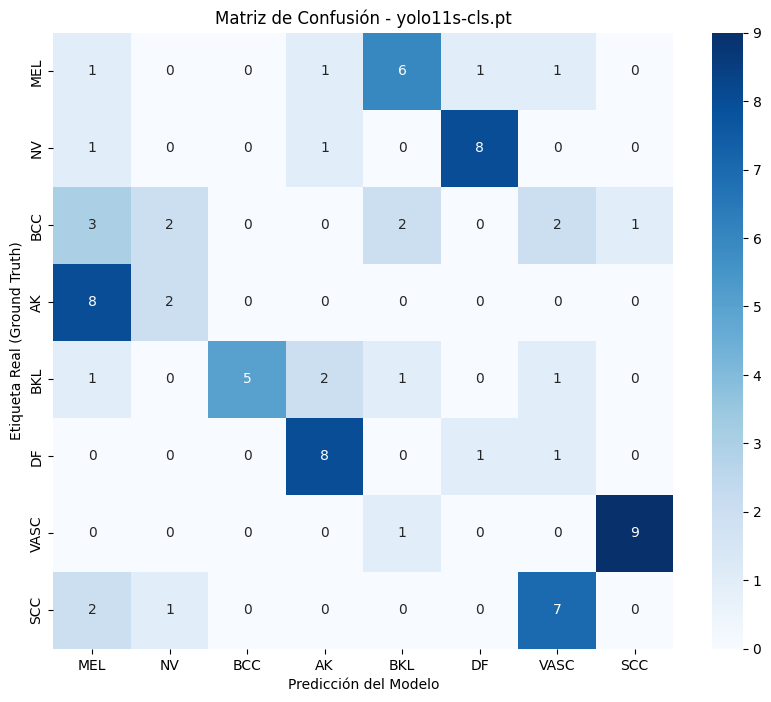


-------------------Evaluando yolo11m-cls.pt-------------------
Cargando modelo: c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Aprendizaje_Automatico\practicas-aprendizaje\practica4\runs\train_yolo11m-cls.pt\weights\best.pt
Accuracy Global: 0.0375

Reporte de Clasificación:
              precision    recall  f1-score   support

         MEL       0.00      0.00      0.00        10
          NV       0.00      0.00      0.00        10
         BCC       0.00      0.00      0.00        10
          AK       0.00      0.00      0.00        10
         BKL       0.10      0.10      0.10        10
          DF       0.08      0.10      0.09        10
        VASC       0.10      0.10      0.10        10
         SCC       0.00      0.00      0.00        10

    accuracy                           0.04        80
   macro avg       0.03      0.04      0.04        80
weighted avg       0.03      0.04      0.04        80



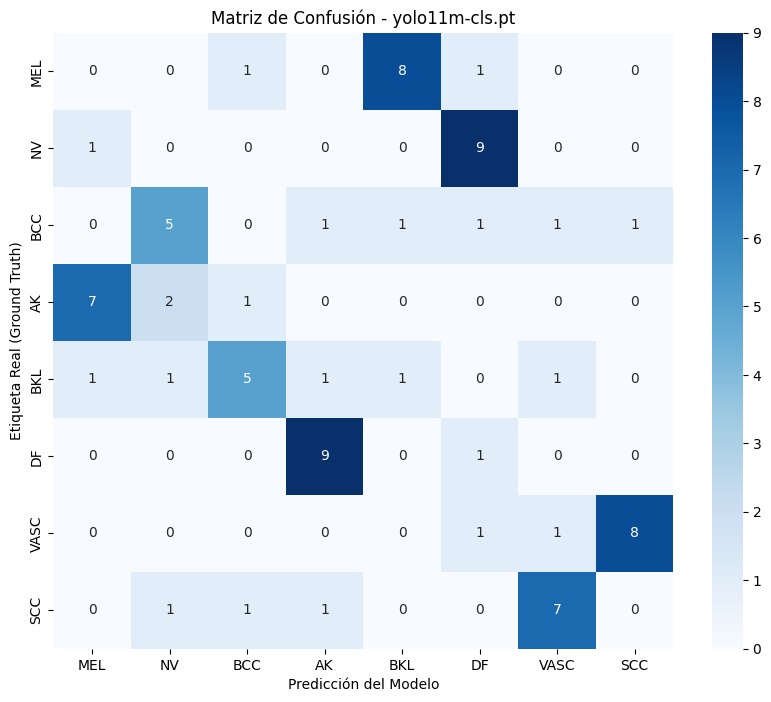


Resumen Final de Accuracy:
Modelo YOLO11N-CLS.PT: 5.00%
Modelo YOLO11S-CLS.PT: 3.75%
Modelo YOLO11M-CLS.PT: 3.75%


In [5]:
results_summary = {}

models = ["yolo11n-cls.pt", "yolo11s-cls.pt", "yolo11m-cls.pt"]

for variant in models:
    # Construimos la ruta al archivo best.pt
    weights_path = os.path.join(PROJECT_PATH, f'train_{variant}', 'weights', 'best.pt')
    
    if not os.path.exists(weights_path):
        print(f"No se encontró el modelo {variant} en {weights_path}. Saltando...")
        continue
        
    print(f"\n-------------------Evaluando {variant}-------------------")
    
    # 1. Obtener predicciones
    y_true, y_pred = evaluate_model(weights_path, TEST_DATA_PATH, target_names)
    
    # 2. Calcular Accuracy Global
    acc = accuracy_score(y_true, y_pred)
    results_summary[variant] = acc
    print(f"Accuracy Global: {acc:.4f}")
    
    # 3. Reporte detallado por clase (Precision, Recall, F1)
    print("\nReporte de Clasificación:")
    print(classification_report(y_true, y_pred, target_names=target_names))
    
    # 4. Matriz de Confusión Gráfica
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicción del Modelo')
    plt.ylabel('Etiqueta Real (Ground Truth)')
    plt.title(f'Matriz de Confusión - {variant}')
    plt.show()

print("\nResumen Final de Accuracy:")
for v, acc in results_summary.items():
    print(f"Modelo {v.upper()}: {acc:.2%}")